<a href="https://colab.research.google.com/github/laurencefrank/Applied-Text-Mining/blob/main/ATM_P7_Thursday.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Applied Text Mining, Utrecht Summerschool 26 - 29 July 2021

Thursday 29 July, practical 7

Practical 7: RNN vs CNN

Welcome to the seventh practical of the course “Applied Text Mining”. In this practical, we will other deep learning architectures including RNN and CNN. We will work with the famous 20 Newsgroups data set from the sklearn library and will apply deep learning models on that using the Keras library.

Today we will use the following libraries. Take care to have them installed!

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import fetch_20newsgroups
from sklearn.preprocessing import LabelEncoder

from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras import layers, utils

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

First run the following lines to make your data ready for the models (we discussed this code in the previous practical):

In [3]:
# select couple of the categories in 20newsgroups
categories = ['rec.sport.hockey', 'talk.politics.mideast', 'soc.religion.christian', 'comp.graphics', 'sci.med']
# fetch the training set
twenty_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), 
                                  categories=categories, shuffle=True, random_state=321)
# fetch the test set
twenty_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), 
                                 categories=categories, shuffle=True, random_state=321)
# convert to a dataframe
df_train = pd.DataFrame(list(zip(twenty_train.data, twenty_train.target)), columns=['text', 'label'])
df_test = pd.DataFrame(list(zip(twenty_test.data, twenty_test.target)), columns=['text', 'label'])
# tokenizer from keras
tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(df_train.text.values)
X_train = tokenizer.texts_to_sequences(df_train.text.values)
X_test = tokenizer.texts_to_sequences(df_test.text.values)
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index for sequence padding
# pad sequence
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
# Encode the list of newsgroups into categorical integer values
lb = LabelEncoder()
y = lb.fit_transform(df_train.label.values)
#y_train = utils.to_categorical(y) code gives error
y_train = utils.np_utils.to_categorical(y)

y = lb.transform(df_test.label.values)
y_test = utils.np_utils.to_categorical(y)

And here the code to a function for plotting the history of training for our neural network model:

In [4]:
plt.style.use('ggplot')
def plot_history(history, val=0):
    acc = history.history['accuracy']
    if val == 1:
        val_acc = history.history['val_accuracy'] # we can add a validation set in our fit function with nn
    loss = history.history['loss']
    if val == 1:
        val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training accuracy')
    if val == 1:
        plt.plot(x, val_acc, 'r', label='Validation accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.title('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    if val == 1:
        plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.title('Loss')
    plt.legend()

## Recurrent neural networks

A recurrent neural network (RNN) is a natural generalization of feed-forward neural networks to sequence data such as text. In contrast to a feed-forward neural network, however, it accepts a new input at every time step (layer). Long-short term memory (LSTM) networks are a variant of RNNs. The LSTM introduces mechanisms to decide what should be remembered and what should be forgotten in learning from text documents.

1. Build a neural network model with an LSTM layer of 100 units. As before, the first layer should be an embedding layer, then the LSTM layer, a Dense layer, and the output Dense layer for the 5 news categories. Compile the model and print its summary.

In [5]:
embedding_dim = 100
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          3811100   
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
Total params: 3,892,565
Trainable params: 3,892,565
Non-trainable params: 0
_________________________________________________________________


The first layer is the Embedded layer that uses 100 length vectors to represent each word. The next layer is the LSTM layer with 100 memory units (smart neurons!). Finally, because this is a classification problem we use a Dense output layer with 5 neurons and a softmax activation function to make 0 or 1 predictions for the five classes.

2. Fit the model in 5 epochs.

In [6]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)

3. Evaluate the accuracy of training and test data using your model and plot the history of fit.

Training Accuracy: 0.6906
Testing Accuracy:  0.6098


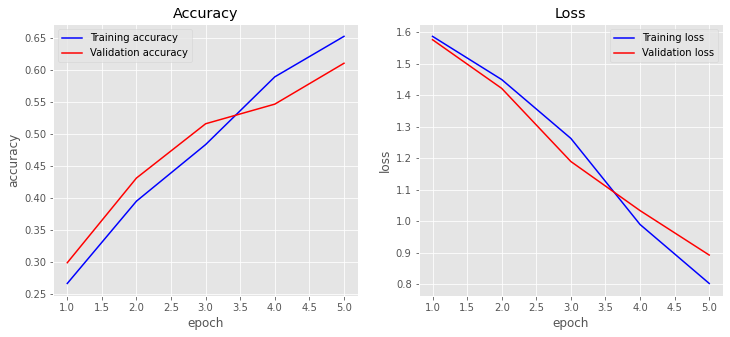

In [7]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

Below we trained the model for 20 more epochs. Check the results:

Training Accuracy: 0.6749
Testing Accuracy:  0.5490


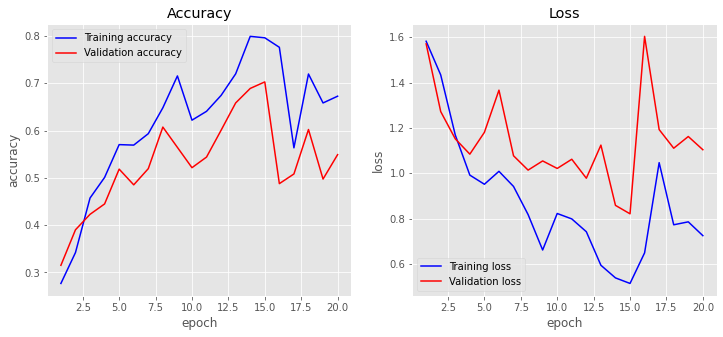

In [8]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

## Convolutional neural networks

Convolutional neural networks or also called convnets are one of the most exciting developments in machine learning in recent years. They have revolutionized image classification and computer vision by being able to extract features from images and using them in neural networks. The properties that made them useful in image processing makes them also handy for sequence processing. When you are working with sequential data, like text, you work with one dimensional convolutions, but the idea and the application stays the same.

4. Build a neural network model with an convolution layer (Conv1D) of 125 units and window size of 5. As before, the first layer should be an embedding layer, then the convolutional layer and a pooling layer, a Dense layer, and the output Dense layer for the 5 news categories. Do you also need a pooling layer? Compile the model and print its summary.

In [9]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          3811100   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
Total params: 3,876,573
Trainable params: 3,876,573
Non-trainable params: 0
_________________________________________________________________


5. Fit the model in 5 epochs, and evaluate the accuracy of training and test data using your model.Also plot the history of fit.

Training Accuracy: 0.9674
Testing Accuracy:  0.8432


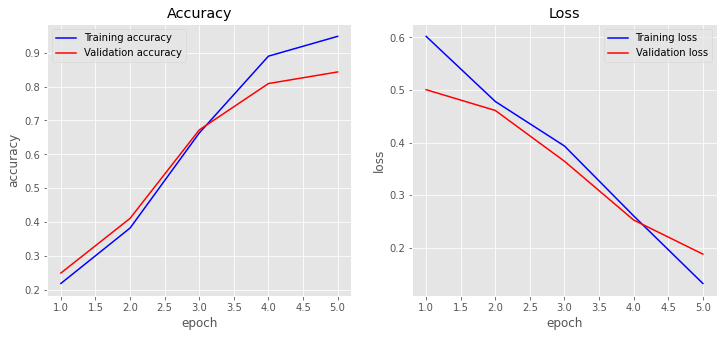

In [10]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

Below we trained the model for 10 epochs. Check the results:

Training Accuracy: 0.9803
Testing Accuracy:  0.8396


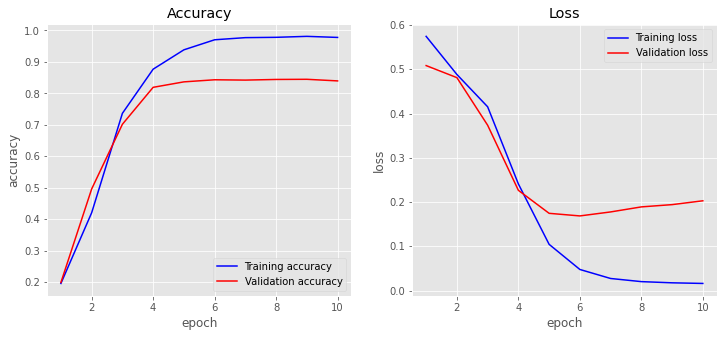

In [11]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

6. How do you compare the performance of the two models also with regard to 5 and 20 iterations?

Look at the plots and discuss your ideas!

Training Accuracy: 0.9779
Testing Accuracy:  0.8468


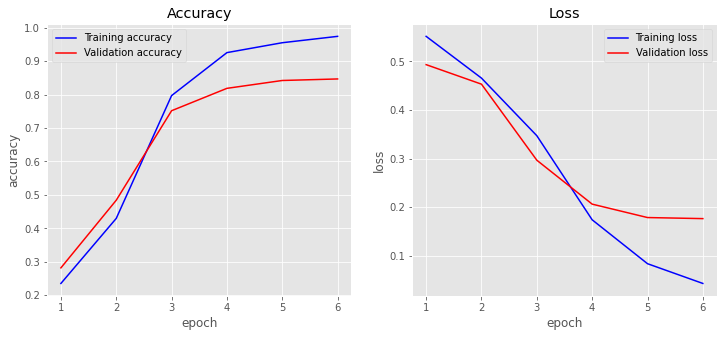

In [12]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=6,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

## Hyperparameter Optimization

One crucial steps of deep learning and working with neural networks is hyperparameter optimization. Hyperparameters are parameters that are chosen by the algorithm designer. Tuning them is very important! One popular method for hyperparameter optimization is grid search. What this method does is it takes lists of parameters and it runs the model with each parameter combination that it can find. It is the most thorough way but also the most computationally heavy way to do this. Another common way, random search, which you’ll see in action here, simply takes random combinations of parameters.

7. Write a function for creating your cnn-based model which has the number of filters, kernel size, embedding size, and maxlen as input arguments. Name your function create_model. For the rest follow the architecture of your previous cnn model.

In [13]:
def create_model(num_filters, kernel_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
    model.add(layers.Conv1D(num_filters, kernel_size, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(5, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

8. Dictionary in Python is an ordered collection of data values. Use the dict structure to define your hyperparameters for the cnn model. You can include the number of filters, kernel size, embedding size, and maxlen.

In [14]:
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],                   
                  embedding_dim=[50, 100],
                  maxlen=[100, 200])

When constructing this structure you must provide a dictionary of hyperparameters to evaluate in the param_grid argument. This is a map of the model parameter name and an array of values to try.

9. Use the scikit-learn classifier API for Keras to create your model with the create_model function, 10 epochs, and batch_size of 64.

In [15]:
# Parameter grid for grid search
model = KerasClassifier(build_fn=create_model,
                        epochs = 10,
                        batch_size=64,
                        verbose=True)

10. Time to call the RandomizedSearchCV function. Use your model, your selected grid for hyperparameters, and 5-fold cross-validation.

In [16]:
grid = RandomizedSearchCV(estimator=model, 
                          param_distributions=param_grid,
                          cv=5, 
                          n_jobs=-1,
                          verbose=1, 
                          n_iter=2)

As you see in this function, there are more input arguments which you can set including n_jobs and n_iter. By default, the random search (or grid search) will only use one thread. By setting the n_jobs argument in the RandomizedSearchCV (or GridSearchCV) constructor to -1, the process will use all cores on your machine. It is also worth mentioning that by default, accuracy is the score that is optimized, but other scores can be specified in the score argument of the GridSearchCV constructor.

11. Fit your grid on X_train and y_train.

In [17]:
grid_result = grid.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  6.2min finished


Epoch 1/10
46/46 [==============================] - 6s 121ms/step - loss: 0.6443 - accuracy: 0.2096
Epoch 2/10
46/46 [==============================] - 6s 120ms/step - loss: 0.4860 - accuracy: 0.2650
Epoch 3/10
46/46 [==============================] - 6s 122ms/step - loss: 0.4099 - accuracy: 0.6223
Epoch 4/10
46/46 [==============================] - 6s 121ms/step - loss: 0.2557 - accuracy: 0.8502
Epoch 5/10
46/46 [==============================] - 6s 121ms/step - loss: 0.1315 - accuracy: 0.9572
Epoch 6/10
46/46 [==============================] - 6s 122ms/step - loss: 0.0599 - accuracy: 0.9707
Epoch 7/10
46/46 [==============================] - 6s 123ms/step - loss: 0.0344 - accuracy: 0.9785
Epoch 8/10
46/46 [==============================] - 6s 123ms/step - loss: 0.0233 - accuracy: 0.9760
Epoch 9/10
46/46 [==============================] - 6s 122ms/step - loss: 0.0209 - accuracy: 0.9790
Epoch 10/10
46/46 [==============================] - 6s 121ms/step - loss: 0.0147 - accuracy: 0.9854

12. Find the best scores and the best values for your hyperparameters.

In [18]:
grid_result.best_params_

{'embedding_dim': 100, 'kernel_size': 7, 'maxlen': 100, 'num_filters': 128}

The `bestscore` member provides access to the best score observed during the optimization procedure and the bestparams describes the combination of parameters that achieved the best results.

13. Evaluate the performance on your test set.

In [19]:
test_accuracy = grid.score(X_test, y_test)
test_accuracy

31/31 [==============================] - 1s 17ms/step - loss: 0.2188 - accuracy: 0.8575


0.8575076460838318

14. Now you can use the best hyperparameter values to build your final model. Do that as a homework!

Training Accuracy: 0.9803
Testing Accuracy:  0.8355


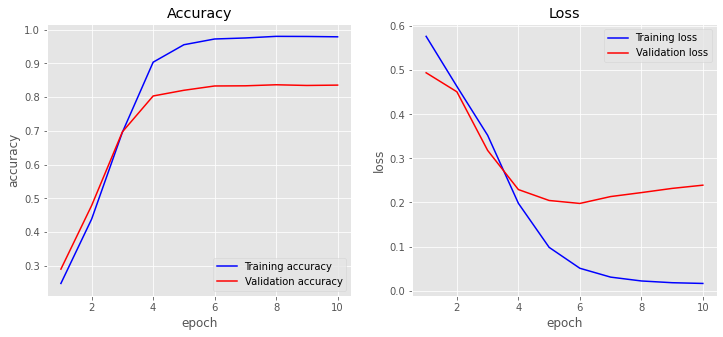

In [25]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)

Now with 4 epochs

Training Accuracy: 0.9524
Testing Accuracy:  0.8146


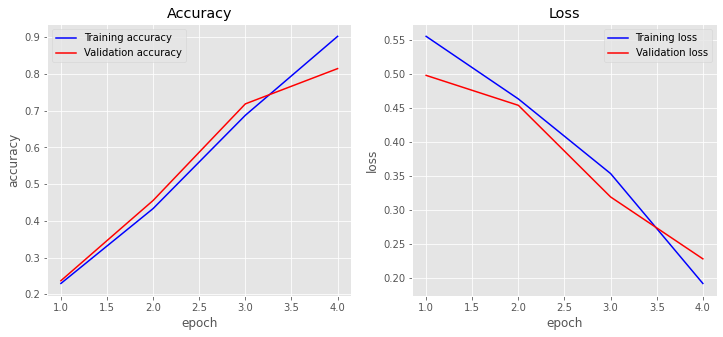

In [26]:
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(5, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train, y_train,
                    epochs=4,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=64)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history, val=1)